In [5]:
import sys
import os
import platform
import importlib
import glob

import datetime

import numpy as np

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs

import HydroAI.Grid as hGrid
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
import HydroAI.SWE as hSWE

importlib.reload(hData);
importlib.reload(hSWE);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

### AMSR-E/AMSR2 data [https://nsidc.org/data/au_dysno/versions/1]
AMSR-E/AMSR2 Unified Level-3 (L3) data set provides daily estimates of Snow Water Equivalent (SWE). SWE was derived from brightness temperature measurements acquired by the Advanced Microwave Scanning Radiometer 2 (AMSR2) instrument on board the JAXA GCOM-W1 satellite. The SWE data is rendered to an azimuthal 25 km Equal-Area Scalable Earth Grid (EASE-Grid) for both the Northern and Southern Hemisphere. Note: This data set uses JAXA AMSR2 Level-1R (L1R) input brightness temperatures that are calibrated, or unified, across the JAXA AMSR-E and JAXA AMSR2 L1R products.

## 1. Import and resample AMSR-E/AMSR2 SWE data (25 km)

In [2]:
# get your AMSRE_AMSR2 he5 file
year = 2015
mission = 'AMSRE_AMSR2'
directory_AMSRE2 = os.path.join(cpuserver_data_FP, 'SWE', mission)
file_list_AMSRE2, data_doy_AMSRE2 = hSWE.extract_filelist_doy_he5(directory_AMSRE2, year)
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.25)
#file_list
#data_doy

In [3]:
# check the variable names and their units
_,units,_ = hData.get_h5_variable_names_units(file_list_AMSRE2[0]);

+------------------------------------------------------------------+-----------------------------------+---------------+
| Name                                                             | Long Name                         | Units         |
+==================================================================+===================================+===============+
| HDFEOS/GRIDS/Northern Hemisphere/Data Fields/Flags_NorthernDaily | QA flag for daily SWE             |               |
+------------------------------------------------------------------+-----------------------------------+---------------+
| HDFEOS/GRIDS/Northern Hemisphere/Data Fields/SWE_NorthernDaily   | Daily snow water equivalent (SWE) | mm            |
+------------------------------------------------------------------+-----------------------------------+---------------+
| HDFEOS/GRIDS/Northern Hemisphere/XDim                            | x-coordinate in Cartesian system  |               |
+-------------------------------

In [6]:
# ??
SWE_AMSRE2_N  = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Northern Hemisphere/Data Fields/SWE_NorthernDaily').astype(float)
flag_AMSRE2_N = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Northern Hemisphere/Data Fields/Flags_NorthernDaily')
lat_AMSRE2_N  = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Northern Hemisphere/lat')
lon_AMSRE2_N  = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Northern Hemisphere/lon')

# mask out inf in lat/lon data
SWE_AMSRE2_N_m = hSWE.replace_inf_with_nan(lat_AMSRE2_N, lon_AMSRE2_N, SWE_AMSRE2_N)
SWE_AMSRE2_N_m[(SWE_AMSRE2_N_m<0) | (SWE_AMSRE2_N_m>20)] = np.nan

In [7]:
# ??
SWE_AMSRE2_S  = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Southern Hemisphere/Data Fields/SWE_SouthernDaily').astype(float)
flag_AMSRE2_S = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Southern Hemisphere/Data Fields/Flags_SouthernDaily')
lat_AMSRE2_S  = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Southern Hemisphere/lat')
lon_AMSRE2_S  = hData.get_variable_from_h5(file_list_AMSRE2[0], 'HDFEOS/GRIDS/Southern Hemisphere/lon')

# mask out inf in lat/lon data
SWE_AMSRE2_S_m = hSWE.replace_inf_with_nan(lat_AMSRE2_S, lon_AMSRE2_S, SWE_AMSRE2_S)
SWE_AMSRE2_S_m[(SWE_AMSRE2_S_m<0) | (SWE_AMSRE2_S_m>20)] = np.nan

In [8]:
# ??
Resampled_SWE_AMSRE2_N = hData.Resampling(domain_lon, domain_lat, lon_AMSRE2_N, lat_AMSRE2_N, SWE_AMSRE2_N_m, sampling_method='nearest', agg_method='mean', mag_factor=2)
Resampled_SWE_AMSRE2_S = hData.Resampling(domain_lon, domain_lat, lon_AMSRE2_S, lat_AMSRE2_S, SWE_AMSRE2_S_m, sampling_method='nearest', agg_method='mean', mag_factor=2)

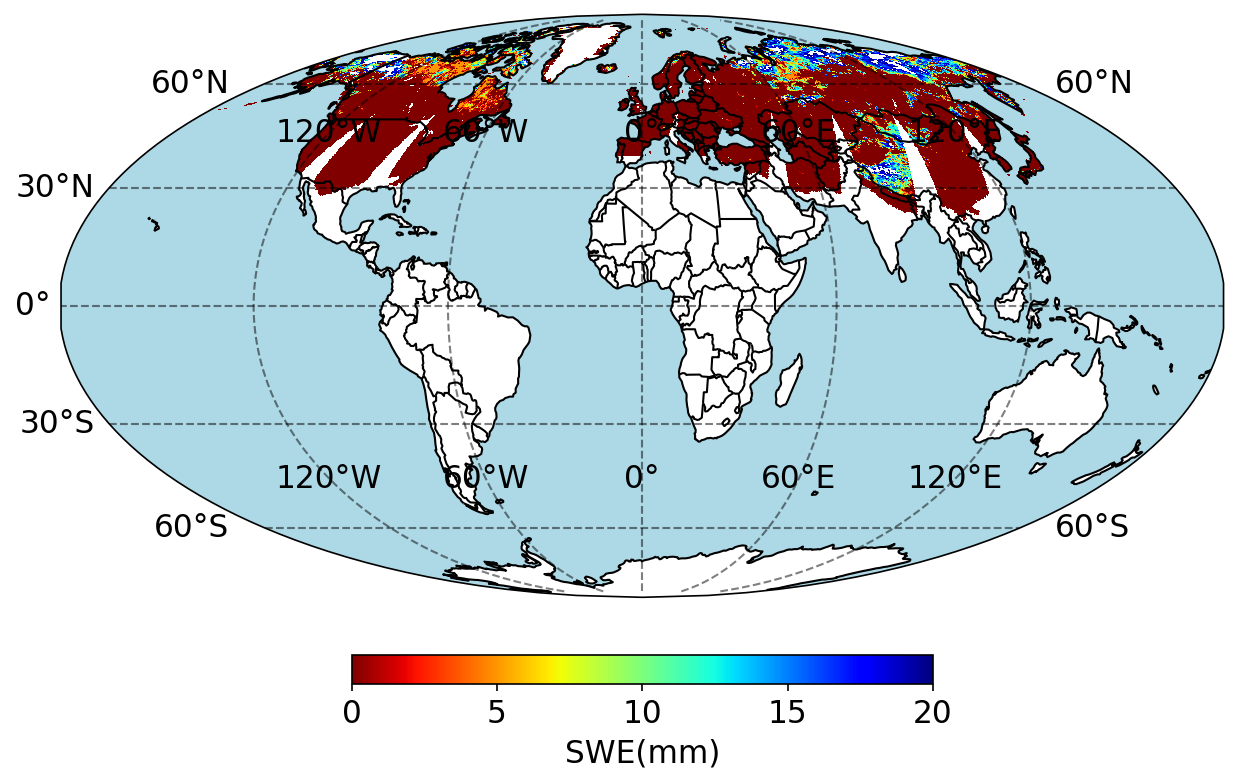

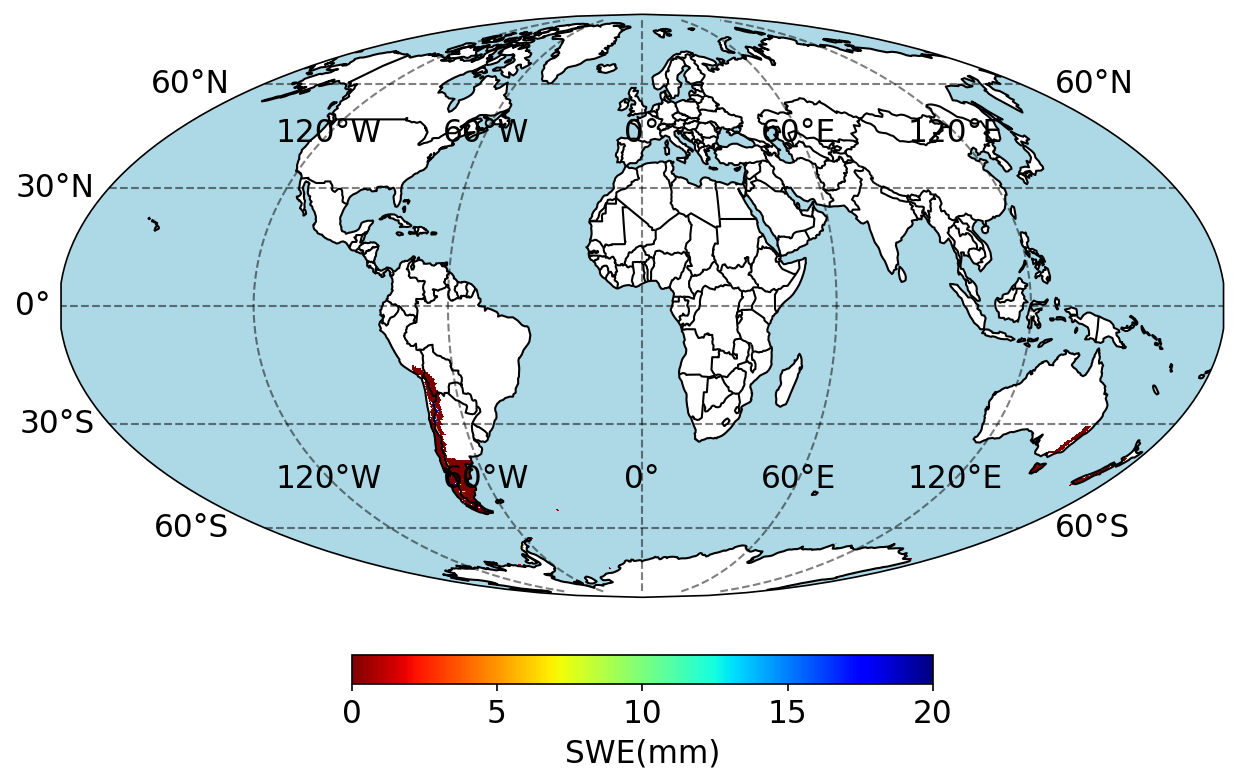

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [9]:
# ??
target = Resampled_SWE_AMSRE2_N 
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='', label_title='SWE(mm)', cmap='jet_r')
target = Resampled_SWE_AMSRE2_S 
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='', label_title='SWE(mm)', cmap='jet_r')

In [ ]:
# save AMSRE-AMSR2 SWE 2015 and 2016 data into nc files